In [1]:
from PS_S2_fusion import *

In [2]:
def save_tif(data, output_file, crs, transform):
    """Saves raster data to a GeoTIFF file.

    Args:
        data (array-like): The 2D or 3D raster data to save.
        output_file (str): The path and filename of the output GeoTIFF file.
        crs (str or rasterio.crs.CRS): The Coordinate Reference System.
              Can be an EPSG code string (e.g., 'EPSG:4326') 
              or a rasterio.crs.CRS object.
        transform (affine.Affine): The affine transformation for the raster.

    Returns:
        None 
    """

    # Determine number of bands
    if data.ndim == 2:
        count = 1
    elif data.ndim == 3:
        count = data.shape[0]  # Assume bands are in the first dimension
    else:
        raise ValueError("Data must be 2D or 3D.")

    profile = {
        'driver': 'GTiff',
        'height': data.shape[1] if data.ndim == 3 else data.shape[0],
        'width': data.shape[2] if data.ndim == 3 else data.shape[1],
        'count': count,
        'dtype': data.dtype.name,  # Use data type of input data
        'crs': crs,
        'transform': transform
    }

    with rasterio.open(output_file, 'w', **profile) as dst:
        if count == 1:
            dst.write(data, 1) 
        else:
            for band_index in range(1, count + 1):
                dst.write(data[band_index - 1], band_index)

In [3]:
# 1. Load NDVI data
data_loader = NDVIDataLoader()
processor = NDVIProcessor()

shapefile_2021_40 = "maize_shp/2021_fid40_maize_utm_10mbuffer.shp"
shapefile_2022_40 = "maize_shp/2022_fid40_maize_utm_10mbuffer.shp"


sentinel_2_images_2021 = data_loader.load_ndvi_images("40/2021_all", "S2*.tif")
planet_scope_images_2021 = data_loader.load_ndvi_images("40/2021_all", "PS*.tif")

sentinel_2_images_2022 = data_loader.load_ndvi_images("40/2022_all", "S2*.tif")
planet_scope_images_2022 = data_loader.load_ndvi_images("40/2022_all", "PS*.tif")

In [4]:
def find_matching_image_pairs(sentinel_images, planet_images, year):
    """
    Finds matching image pairs from Sentinel-2 and PlanetScope dictionaries
    based on DOY with a descriptive output.

    Args:
        sentinel_images: Dictionary with DOY as key and Sentinel-2 NDVI data as value.
        planet_images: Dictionary with DOY as key and PlanetScope NDVI data as value.

    Returns:
        A list of dictionaries, where each dictionary represents a match:
            {'planet_doy': ...,
             'sentinel_matching_doy': ...,
             'sentinel_before_doy': ...,
             'sentinel_after_doy': ...}
    """
    matching_pairs = []

    for planet_doy in planet_images:
        for doy_offset in range(-3, 4):  # Check DOY ± 3 days
            matching_sentinel_doy = planet_doy + doy_offset
            if matching_sentinel_doy in sentinel_images:
                # Find nearest before/after Sentinel images
                sentinel_before_doy = max(
                    [doy for doy in sentinel_images if doy < matching_sentinel_doy]
                )
                sentinel_after_doy = min(
                    [doy for doy in sentinel_images if doy > matching_sentinel_doy]
                )
                matching_pairs.append(
                    {
                        "year": year,
                        "planet_doy": planet_doy,
                        "sentinel_matching_doy": matching_sentinel_doy,
                        "sentinel_before_doy": sentinel_before_doy,
                        "sentinel_after_doy": sentinel_after_doy,
                    }
                )
                break  # Move on to the next PlanetScope image after a match

    return matching_pairs

In [5]:
# Example usage with your dictionaries:
matching_pairs_2022 = find_matching_image_pairs(
    sentinel_2_images_2022, planet_scope_images_2022, 2022
)

matching_pairs_2021 = find_matching_image_pairs(
    sentinel_2_images_2021, planet_scope_images_2021, 2021
)

In [6]:
matching_pairs = matching_pairs_2021 + matching_pairs_2022
validation_pairs = random.sample(matching_pairs, 5)

training_pairs = [
    element for element in matching_pairs if element not in validation_pairs
]

In [7]:
def create_feature_target_pair(
    match,
    sentinel_images: Dict[int, NDVIImage],
    planet_images: Dict[int, NDVIImage],
    shapefile_path: str,
):
    """
    Creates a single feature array (X) and target array (y) pair
    for one set of matching images.

    Args:
        match: A single dictionary from the matching_pairs list.
        sentinel_images: Dictionary with DOY as key and Sentinel-2 NDVIImage.
        planet_images: Dictionary with DOY as key and PlanetScope NDVIImage.

    Returns:
        A tuple: (features (X), targets (y))
            - features (X): 2D NumPy array of features, one row per valid pixel.
            - targets (y): 1D NumPy array of corresponding Sentinel-2 NDVI.
    """
    processor = NDVIProcessor()

    year = match["year"]
    planet_doy = match["planet_doy"]
    sentinel_matching_doy = match["sentinel_matching_doy"]
    sentinel_before_doy = match["sentinel_before_doy"]
    sentinel_after_doy = match["sentinel_after_doy"]

    # Resample PlanetScope
    planet_image = processor.resample_planet_to_sentinel(
        sentinel_images[sentinel_matching_doy], planet_images[planet_doy]
    )

    # Extract pixel data
    sentinel_matching_image = sentinel_images[sentinel_matching_doy]
    sentinel_before_image = sentinel_images[sentinel_before_doy]
    sentinel_after_image = sentinel_images[sentinel_after_doy]

    # exclude maize
    planet_image.ndvi = processor.mask_array_with_shapefile(
        planet_image.ndvi, planet_image.transform, shapefile_path
    )
    sentinel_matching_image.ndvi = processor.mask_array_with_shapefile(
        sentinel_matching_image.ndvi, sentinel_matching_image.transform, shapefile_path
    )
    sentinel_before_image.ndvi = processor.mask_array_with_shapefile(
        sentinel_before_image.ndvi, sentinel_before_image.transform, shapefile_path
    )
    sentinel_after_image.ndvi = processor.mask_array_with_shapefile(
        sentinel_after_image.ndvi, sentinel_after_image.transform, shapefile_path
    )

    # ... (Your processing with invalid_mask as before)
    invalid_mask_matching = processor.get_invalid_mask(
        sentinel_ndvi_data=sentinel_matching_image.ndvi,
        planet_ndvi_data=planet_image.ndvi,
    )

    invalid_mask_before_after = processor.get_invalid_mask(
        sentinel_before_image.ndvi, sentinel_after_image.ndvi
    )

    invalid_mask = np.logical_or(invalid_mask_matching, invalid_mask_before_after)

    sentinel_matching_data = processor.get_preprocessed_ndiv_data(
        sentinel_matching_image, invalid_mask
    ).flatten()
    sentinel_before_data = processor.get_preprocessed_ndiv_data(
        sentinel_before_image, invalid_mask
    ).flatten()
    sentinel_after_data = processor.get_preprocessed_ndiv_data(
        sentinel_after_image, invalid_mask
    ).flatten()
    planet_data = processor.get_preprocessed_ndiv_data(
        planet_image, invalid_mask
    ).flatten()

    # masking maize

    num_valid_pixels = len(sentinel_matching_data)

    # Create feature matrix (one row per valid pixel)
    features = np.column_stack(
        (
            planet_data,
            sentinel_before_data,
            sentinel_after_data,
            np.full(num_valid_pixels, planet_doy),  # Repeat DOY for all pixels
            np.full(num_valid_pixels, sentinel_before_doy),
            np.full(num_valid_pixels, sentinel_after_doy),
            np.full(num_valid_pixels, year),
        )
    )

    targets = sentinel_matching_data

    return features, targets, invalid_mask

In [8]:
# Example usage: Process data for each match in a loop
all_features = []
all_targets = []
all_masks = []
for match in training_pairs:
    if match["year"] == 2022:
        X, y, invalid_mask = create_feature_target_pair(
            match,
            sentinel_2_images_2022,
            planet_scope_images_2022,
            shapefile_2022_40,
        )
    else:
        X, y, invalid_mask = create_feature_target_pair(
            match,
            sentinel_2_images_2021,
            planet_scope_images_2021,
            shapefile_2021_40,
        )

    all_features.append(X)
    all_targets.append(y)
    all_masks.append(invalid_mask)

# Concatenate the results if needed
X = np.concatenate(all_features, axis=0)
y = np.concatenate(all_targets)

print(X.shape, y.shape)

(4892067, 7) (4892067,)


In [9]:
lr_model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
lr_model.fit(X_train, y_train)

predictions = lr_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print(mse)

0.0023747233301620123


In [10]:
rf_model = RandomForestRegressor(
    n_estimators=40, max_depth=15, random_state=42, n_jobs=8
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print(mse)

0.0012402019361912933


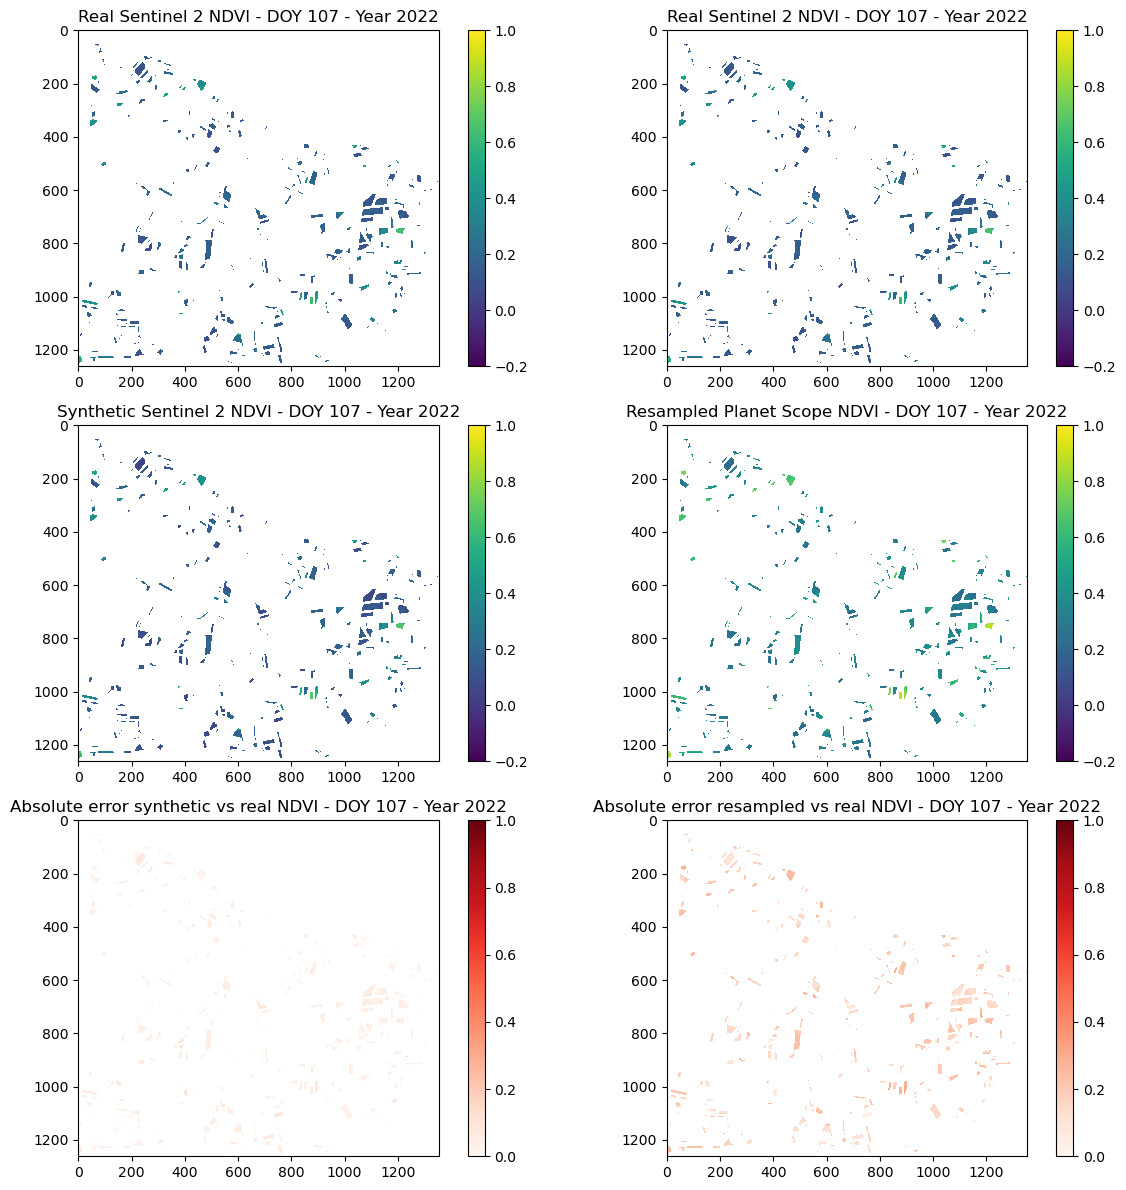

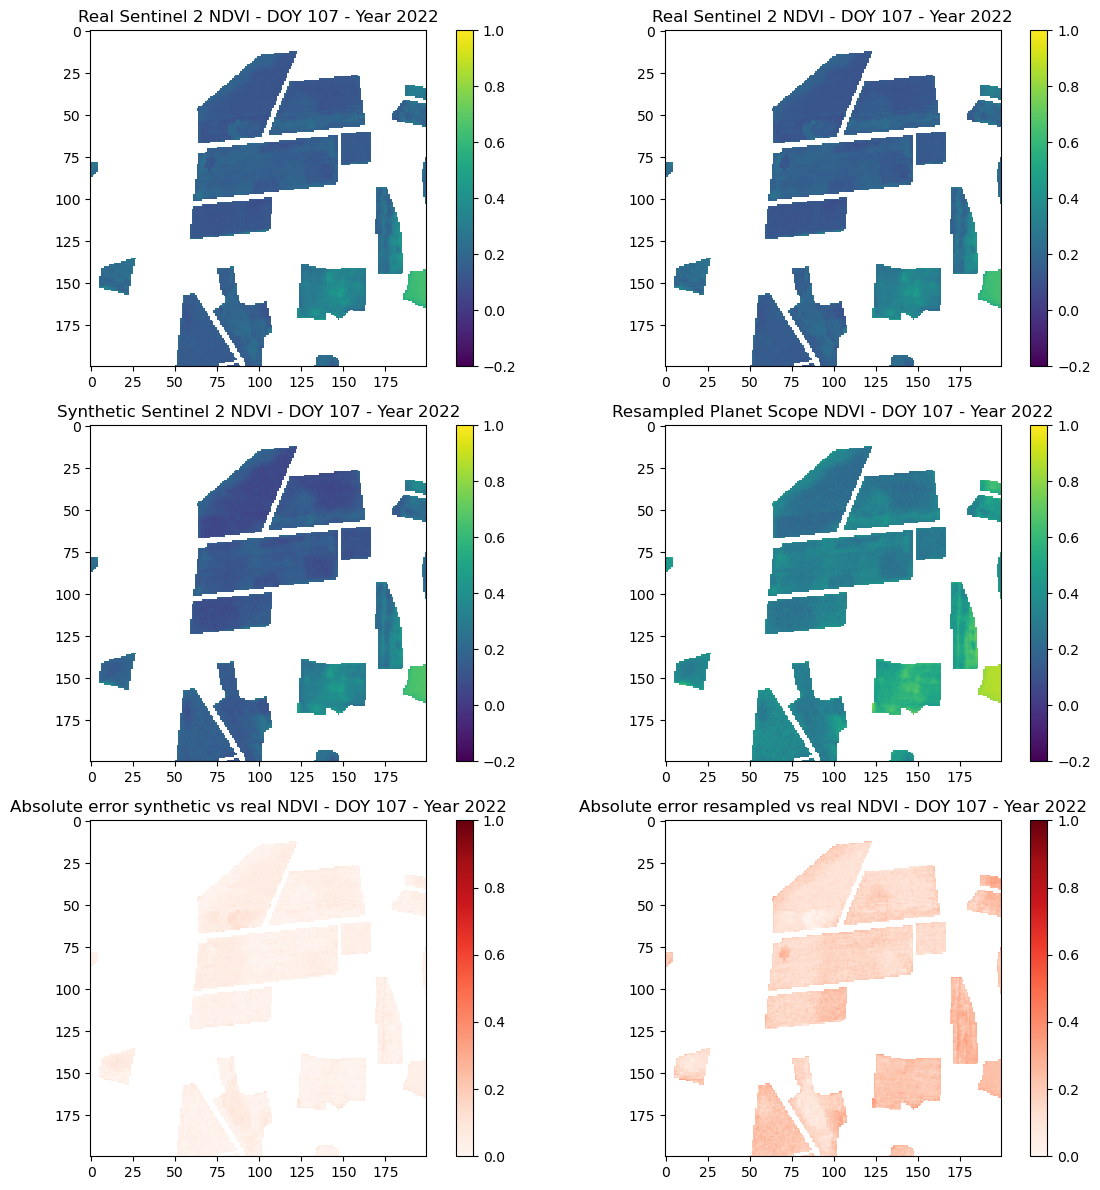

Mean Squared Error for Synthetic Planetscope DOY 107: 0.001683630933226326
Mean Squared Error for Resampled Planetscope DOY 107: 0.03717946261167526


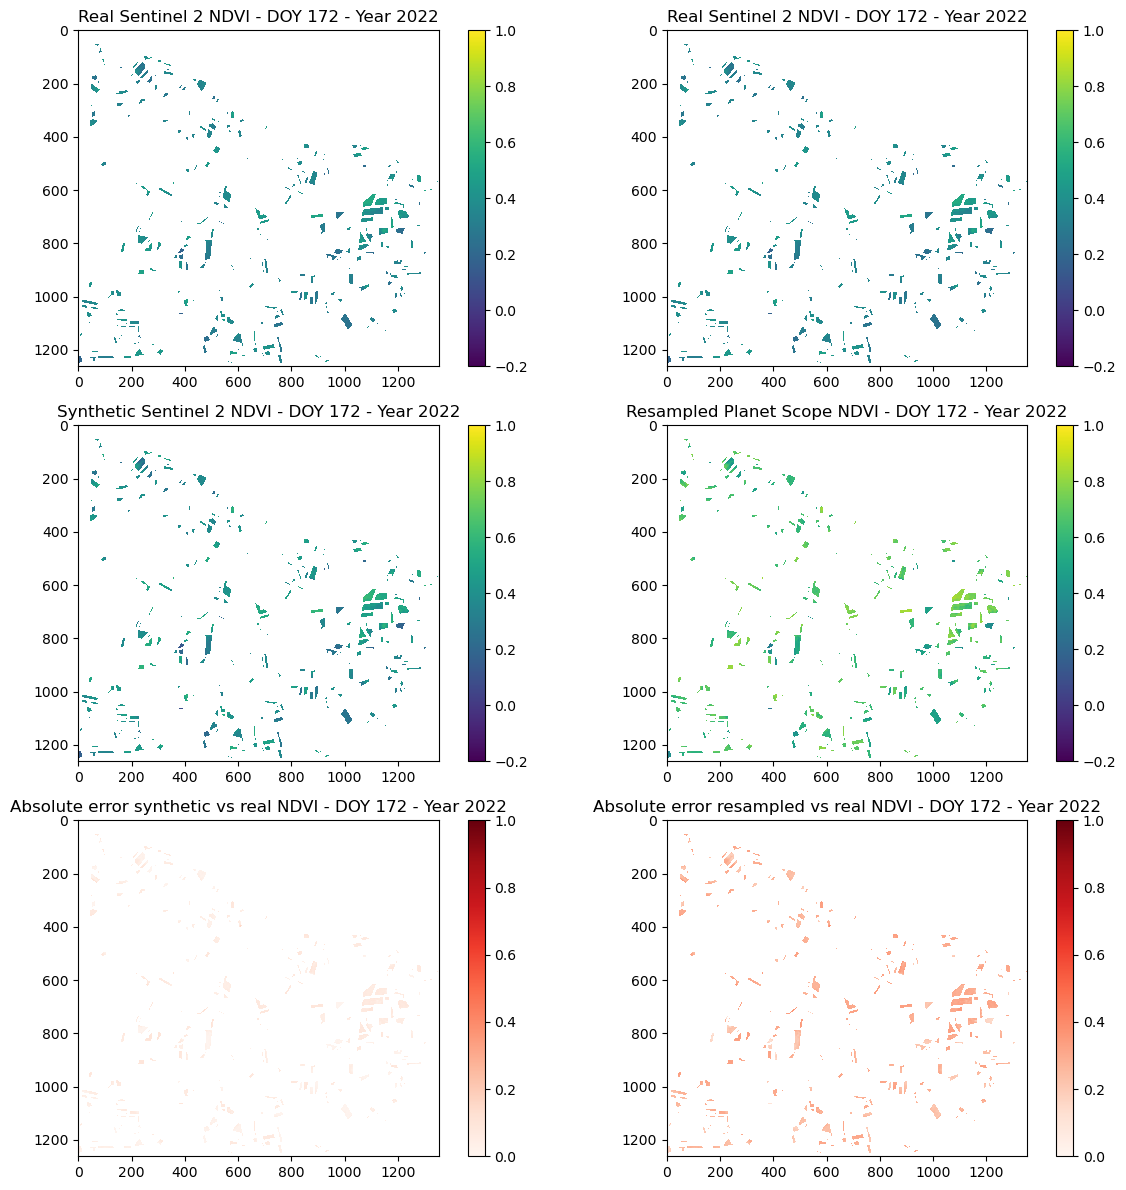

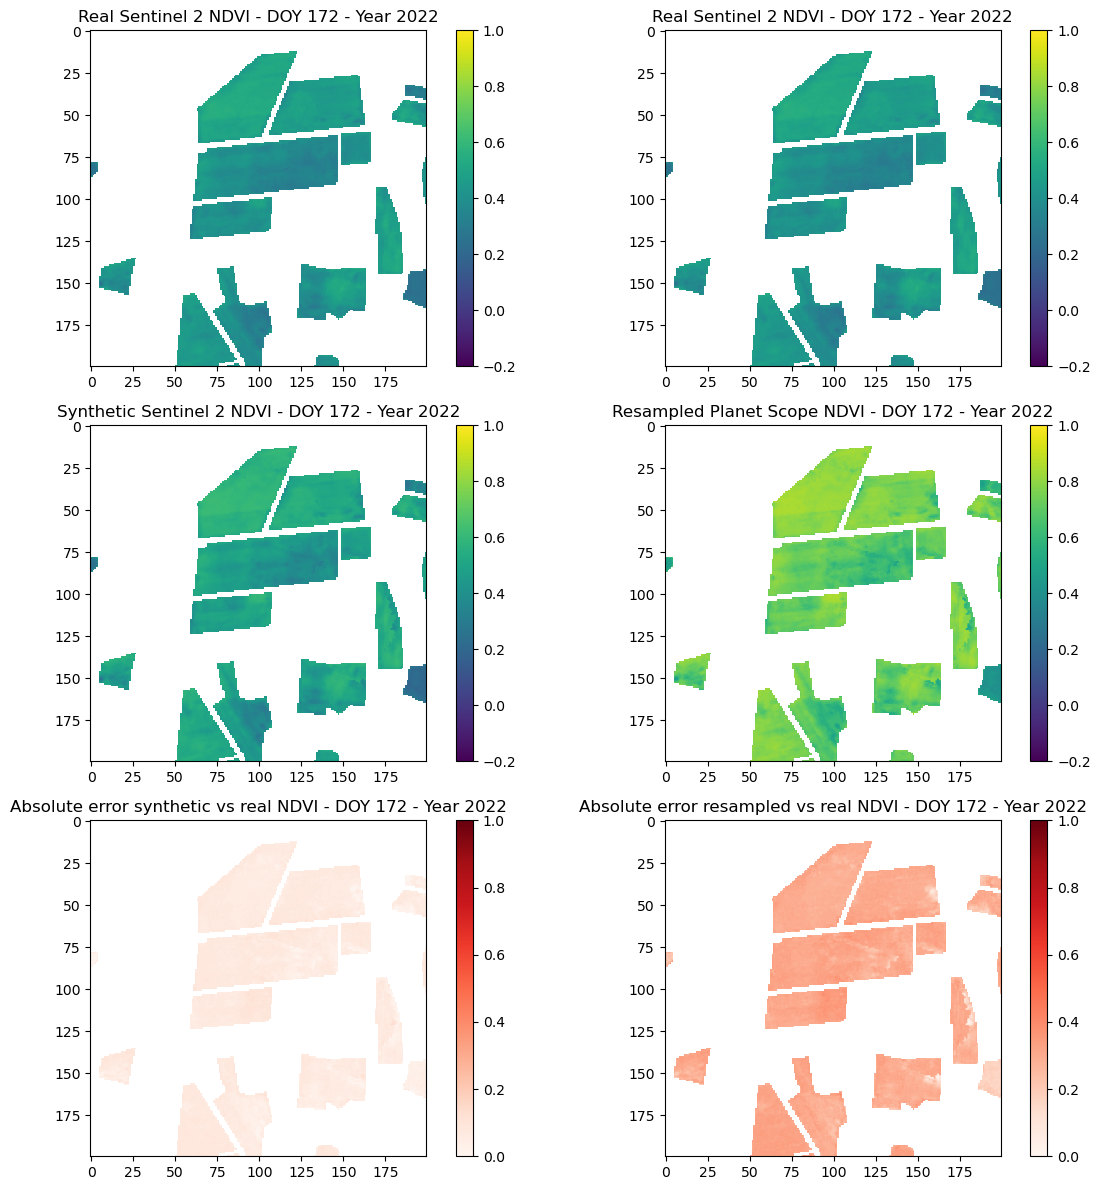

Mean Squared Error for Synthetic Planetscope DOY 172: 0.00290669528339337
Mean Squared Error for Resampled Planetscope DOY 172: 0.07480375468730927


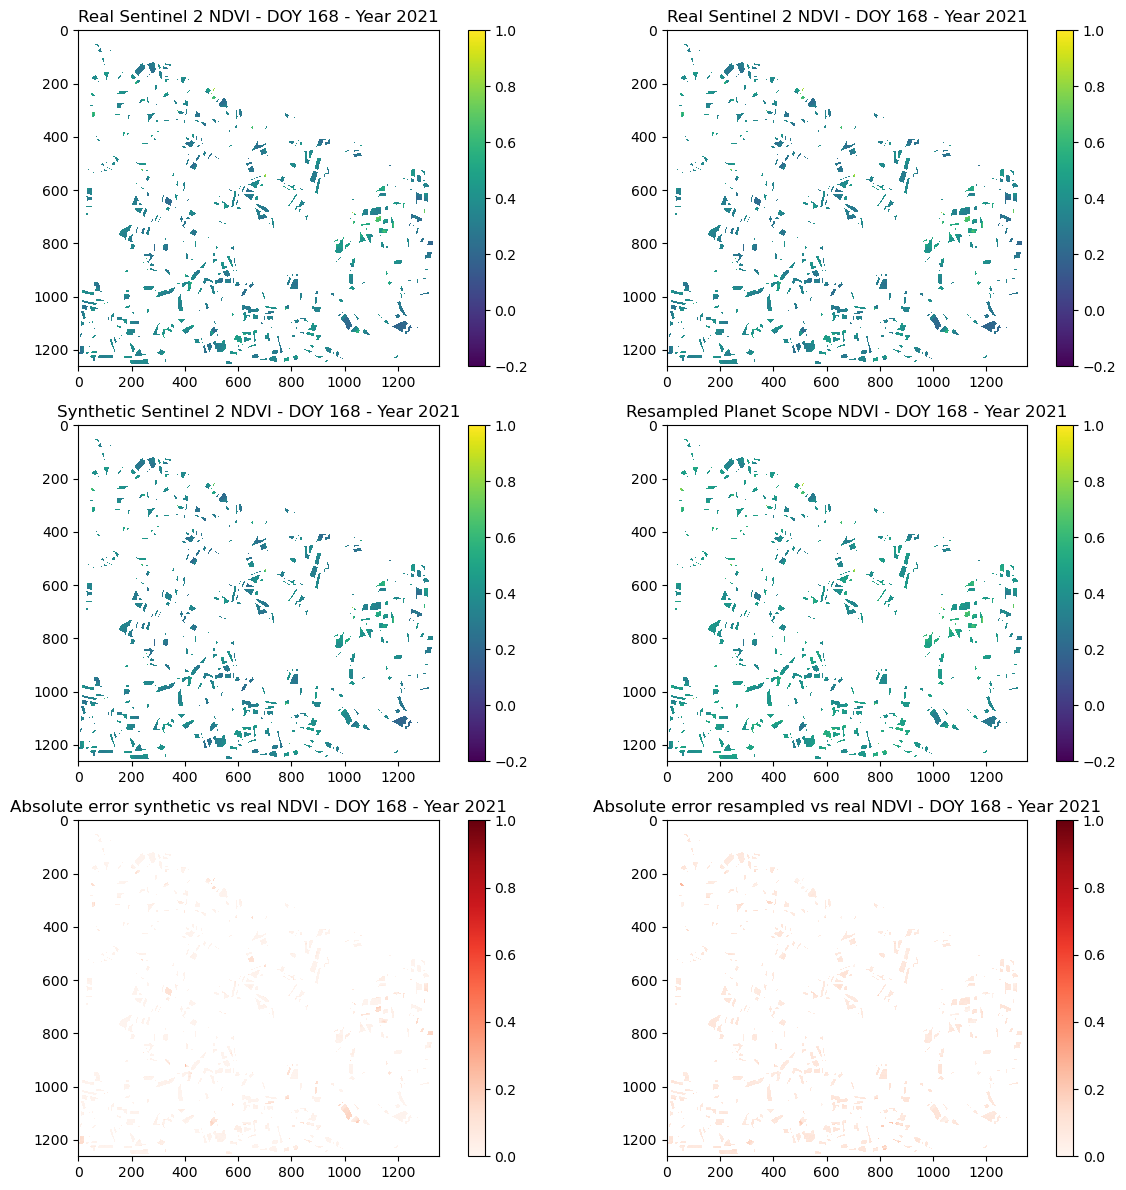

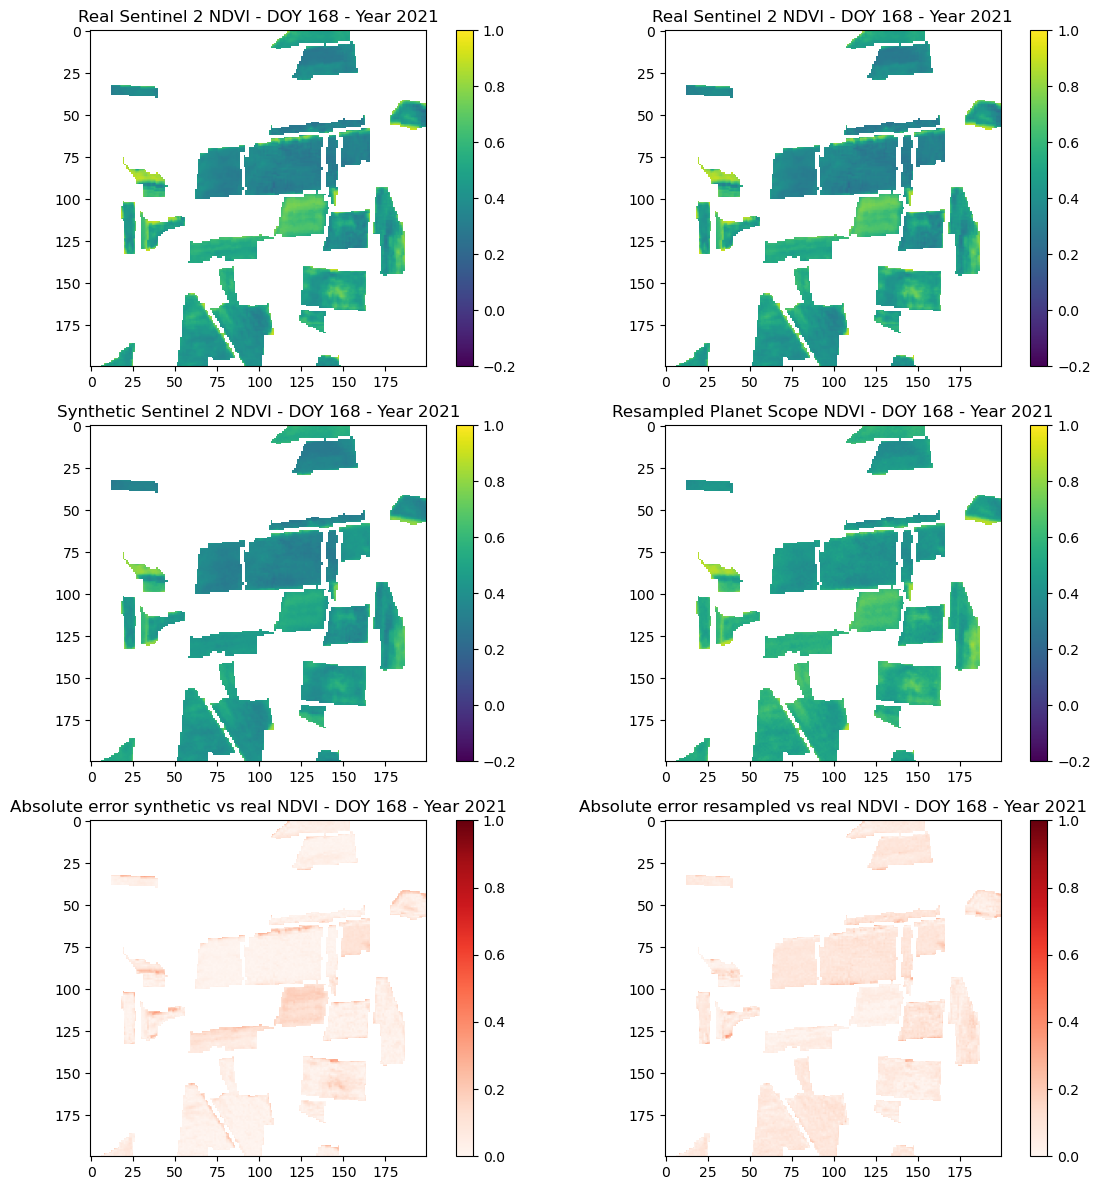

Mean Squared Error for Synthetic Planetscope DOY 168: 0.004124508590951933
Mean Squared Error for Resampled Planetscope DOY 168: 0.008268403820693493


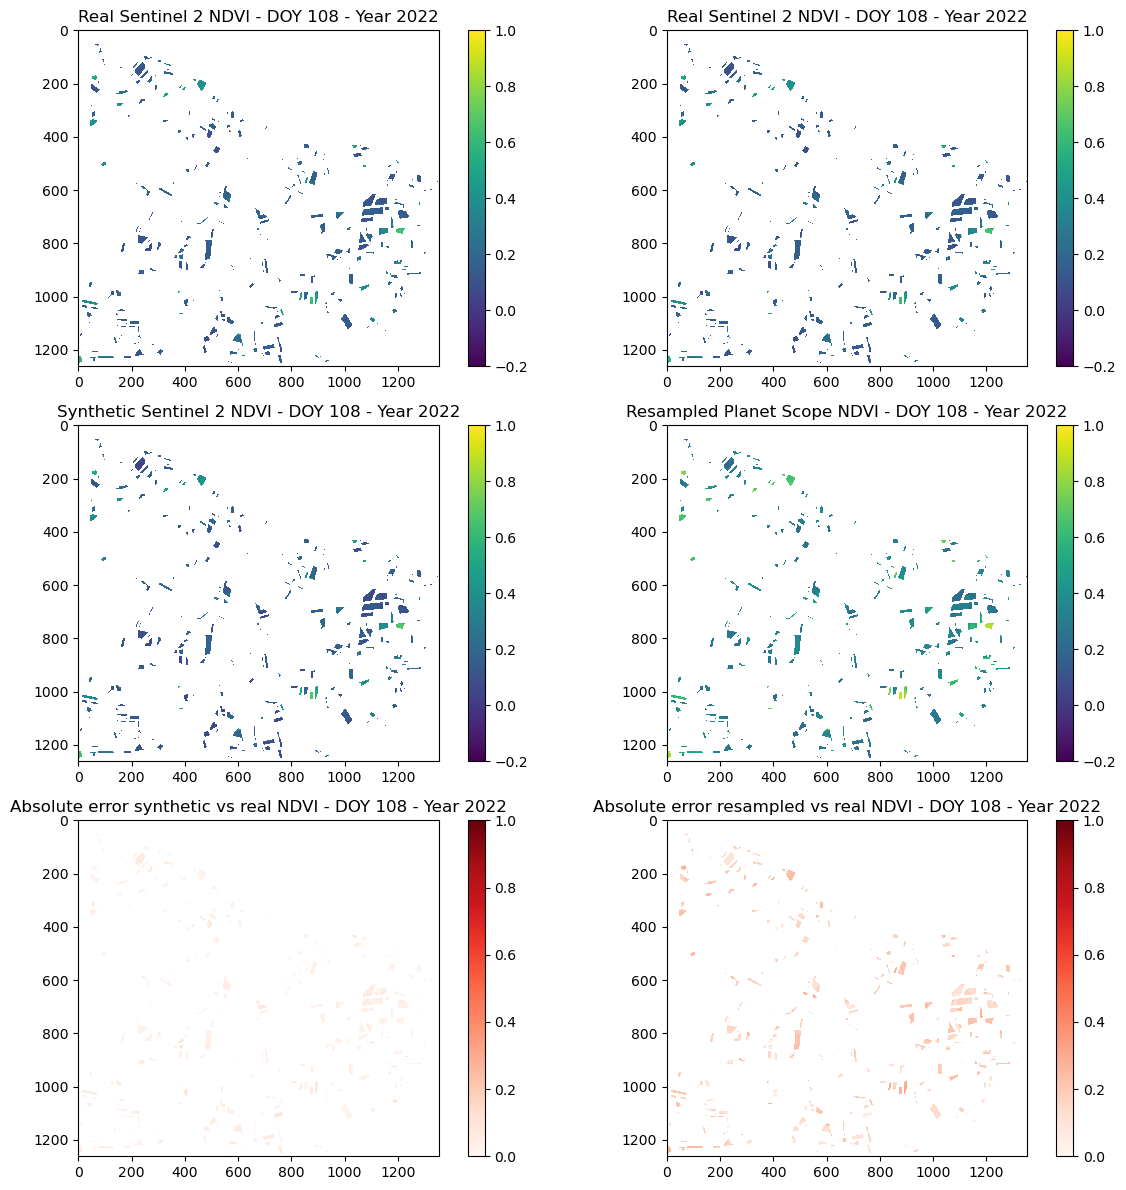

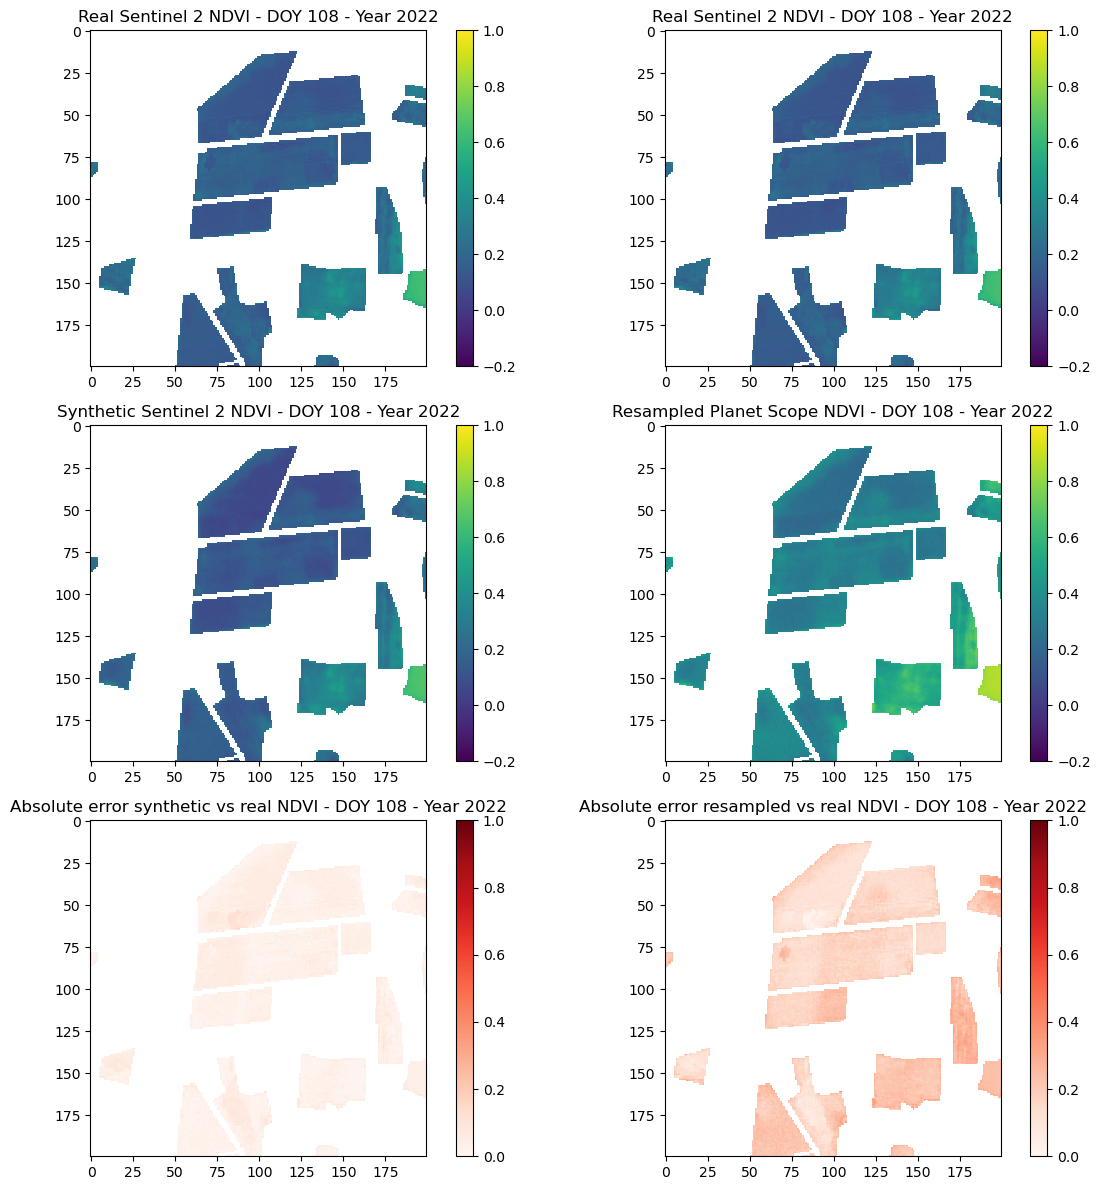

Mean Squared Error for Synthetic Planetscope DOY 108: 0.0016350972000874627
Mean Squared Error for Resampled Planetscope DOY 108: 0.03833768889307976


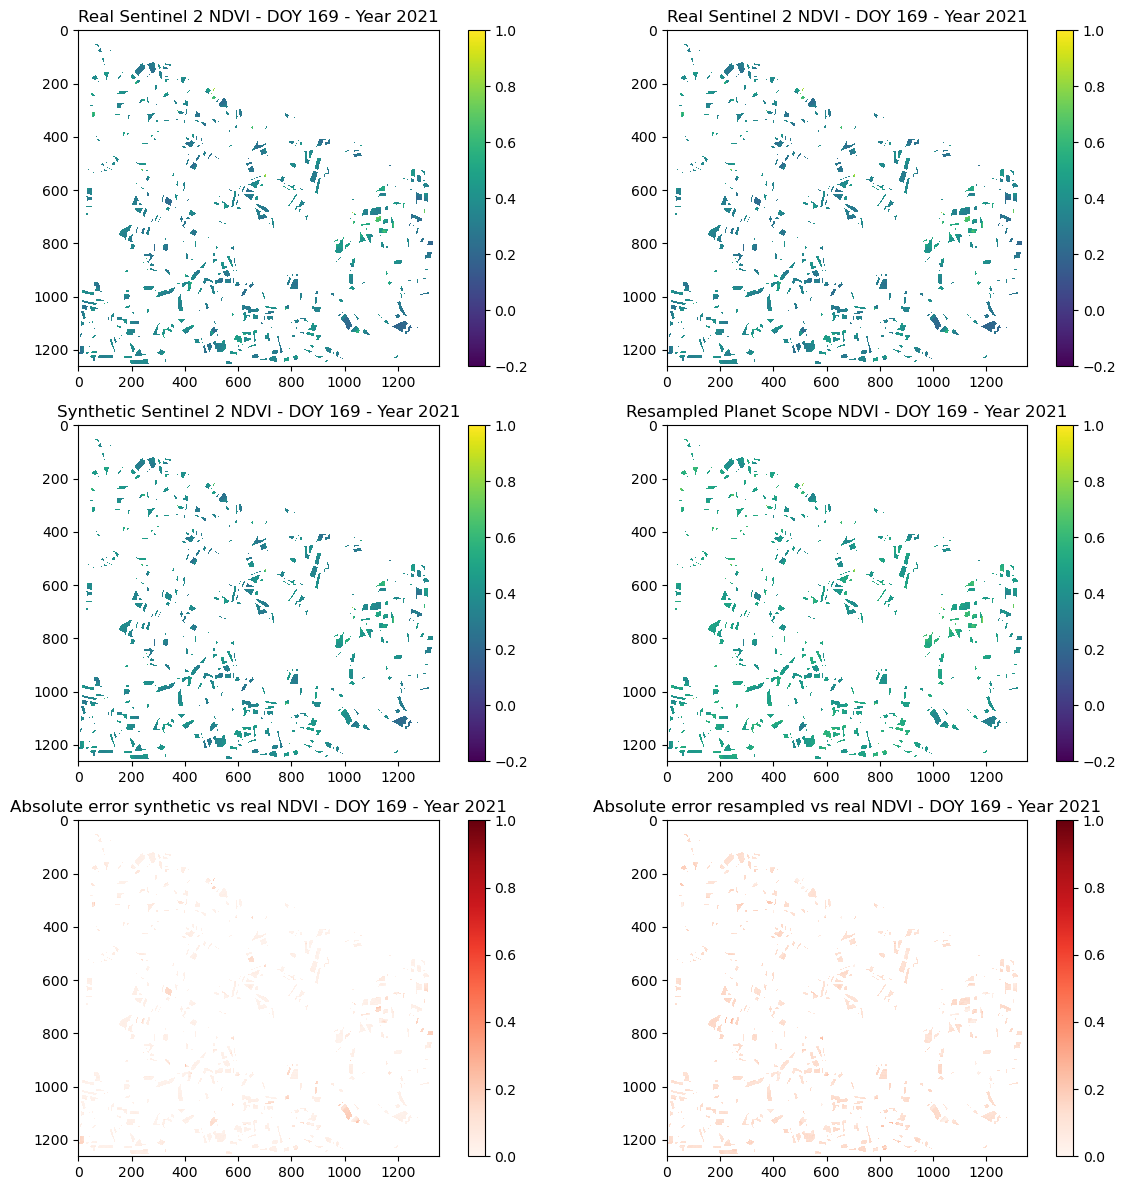

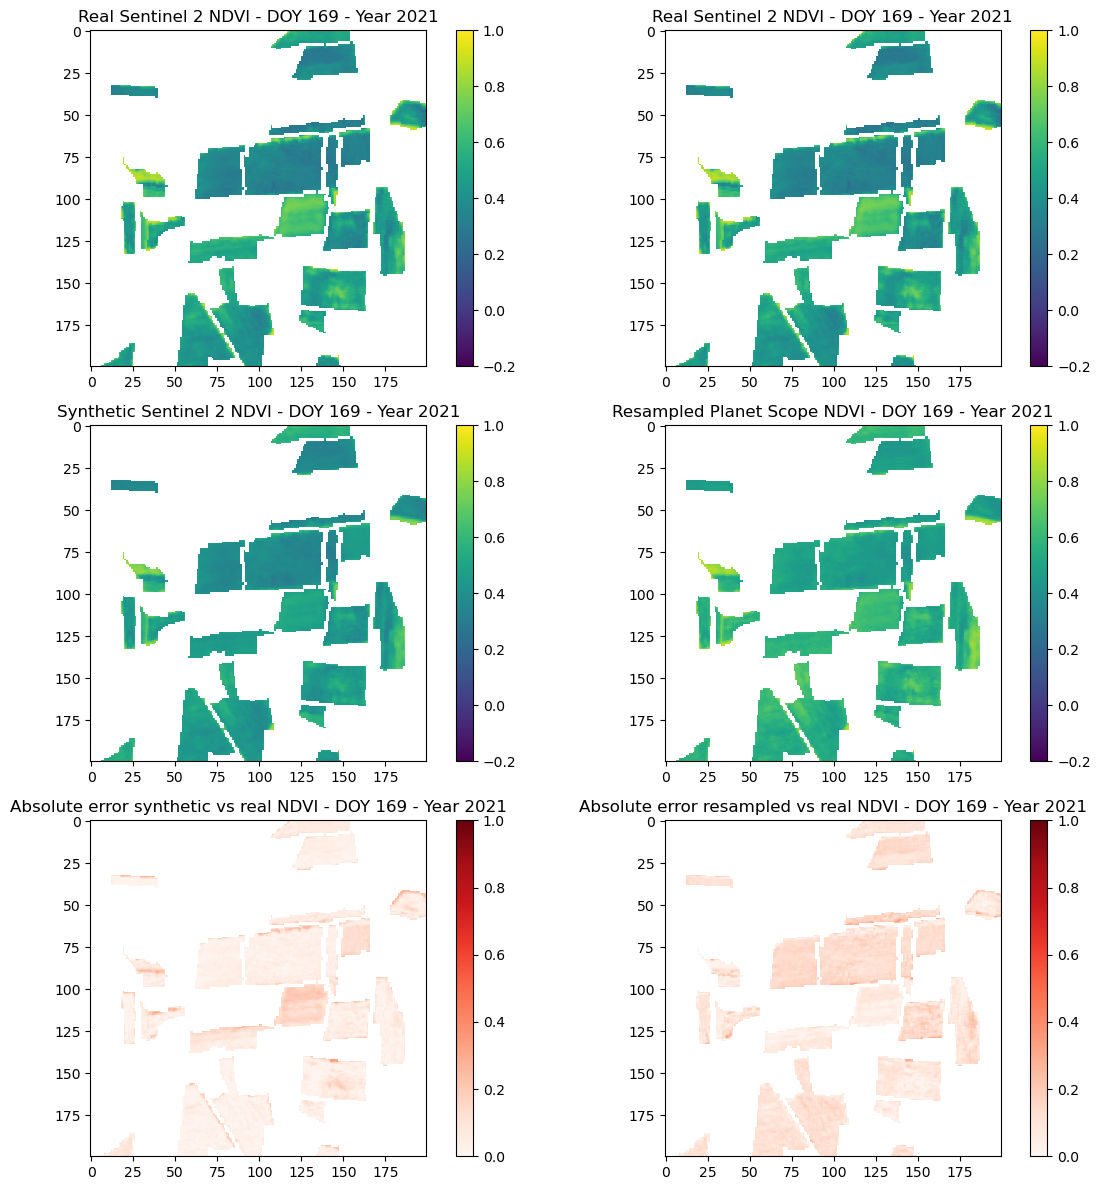

Mean Squared Error for Synthetic Planetscope DOY 169: 0.005103276420327308
Mean Squared Error for Resampled Planetscope DOY 169: 0.016183366999030113


In [11]:
import copy

all_features = []
all_targets = []
all_masks = []
for match in validation_pairs:
    if match["year"] == 2021:
        X, y, invalid_mask = create_feature_target_pair(
            match,
            sentinel_2_images_2021,
            planet_scope_images_2021,
            shapefile_2021_40,
        )
    else:
        X, y, invalid_mask = create_feature_target_pair(
            match,
            sentinel_2_images_2022,
            planet_scope_images_2022,
            shapefile_2022_40,
        )
    all_features.append(X)
    all_targets.append(y)
    all_masks.append(invalid_mask)

# Evaluate and visualize within a single loop
mse_dict_synth = {}
mse_dict_resampled = {}
mean_ndiv_dict_synth = {}
mean_ndiv_dict_resampled = {}
mean_ndiv_dict_real = {}
for i, match in enumerate(validation_pairs):
    year = match["year"]
    if year == 2022:
        sentinel_2_images = sentinel_2_images_2022
        planet_scope_images = planet_scope_images_2022
    else:
        sentinel_2_images = sentinel_2_images_2021
        planet_scope_images = planet_scope_images_2021

    planet_doy = match["planet_doy"]
    sentinel_matching_doy = match["sentinel_matching_doy"]

    # Make predictions
    predictions = lr_model.predict(all_features[i])

    # Create synthetic image
    synth_image = copy.deepcopy(sentinel_2_images[sentinel_matching_doy])
    synth_image.ndvi[~all_masks[i]] = predictions

    save_tif(synth_image.ndvi, f"output/{year}-{planet_doy}-linear.tif", synth_image.crs, synth_image.transform)

    # Resampled PlanetScope for comparison
    resampled_image = processor.resample_planet_to_sentinel(
        sentinel_2_images[sentinel_matching_doy],
        planet_scope_images[planet_doy],
    )
    if year == 2022:
        resampled_image.ndvi = processor.mask_array_with_shapefile(
            resampled_image.ndvi,
            resampled_image.transform,
            "maize_shp/2022_fid40_maize_utm_10mbuffer.shp",
        )
    else:
        resampled_image.ndvi = processor.mask_array_with_shapefile(
            resampled_image.ndvi,
            resampled_image.transform,
            "maize_shp/2021_fid40_maize_utm_10mbuffer.shp",
        )

    # Visualize using your NDVIVisualizer
    visualizer = NDVIVisualizer()
    visualizer.visualize_ndvi_images(
        sentinel_2_images[sentinel_matching_doy].ndvi,
        synth_image.ndvi,
        resampled_image.ndvi,
        planet_doy,
        year
    )

    cropout_sentinel_2_ndvi = sentinel_2_images[sentinel_matching_doy].ndvi[
        600:800, 1000:1200
    ]
    cropout_synth_ndvi = synth_image.ndvi[600:800, 1000:1200]
    cropout_resampled_ndvi = resampled_image.ndvi[600:800, 1000:1200]

    visualizer.visualize_ndvi_images(
        cropout_sentinel_2_ndvi,
        cropout_synth_ndvi,
        cropout_resampled_ndvi,
        planet_doy,
        year
    )

    # Calculate MSE
    mse_synth = mean_squared_error(all_targets[i], predictions)

    print(f"Mean Squared Error for Synthetic Planetscope DOY {planet_doy}: {mse_synth}")

    mse_resampled = mean_squared_error(
        all_targets[i],
        processor.get_preprocessed_ndiv_data(resampled_image, all_masks[i]),
    )

    print(
        f"Mean Squared Error for Resampled Planetscope DOY {planet_doy}: {mse_resampled}"
    )

    mse_dict_synth[planet_doy] = mse_synth
    mse_dict_resampled[planet_doy] = mse_resampled
    mean_ndiv_dict_synth[planet_doy] = np.mean(predictions)
    mean_ndiv_dict_resampled[planet_doy] = np.nanmean(resampled_image.ndvi)
    mean_ndiv_dict_real[planet_doy] = np.nanmean(
        sentinel_2_images[sentinel_matching_doy].ndvi
    )


visualizer.plot_time_series(mse_dict_synth, mse_dict_resampled, mean_ndiv_dict_synth, mean_ndiv_dict_resampled, mean_ndiv_dict_real)

In [12]:
print(f"Total Error Resampled: {sum(mse_dict_resampled.values())}")
print(f"Total Error Synthetic: {sum(mse_dict_synth.values())}")

Total Error Resampled: 0.1747726770117879
Total Error Synthetic: 0.0154532084279864


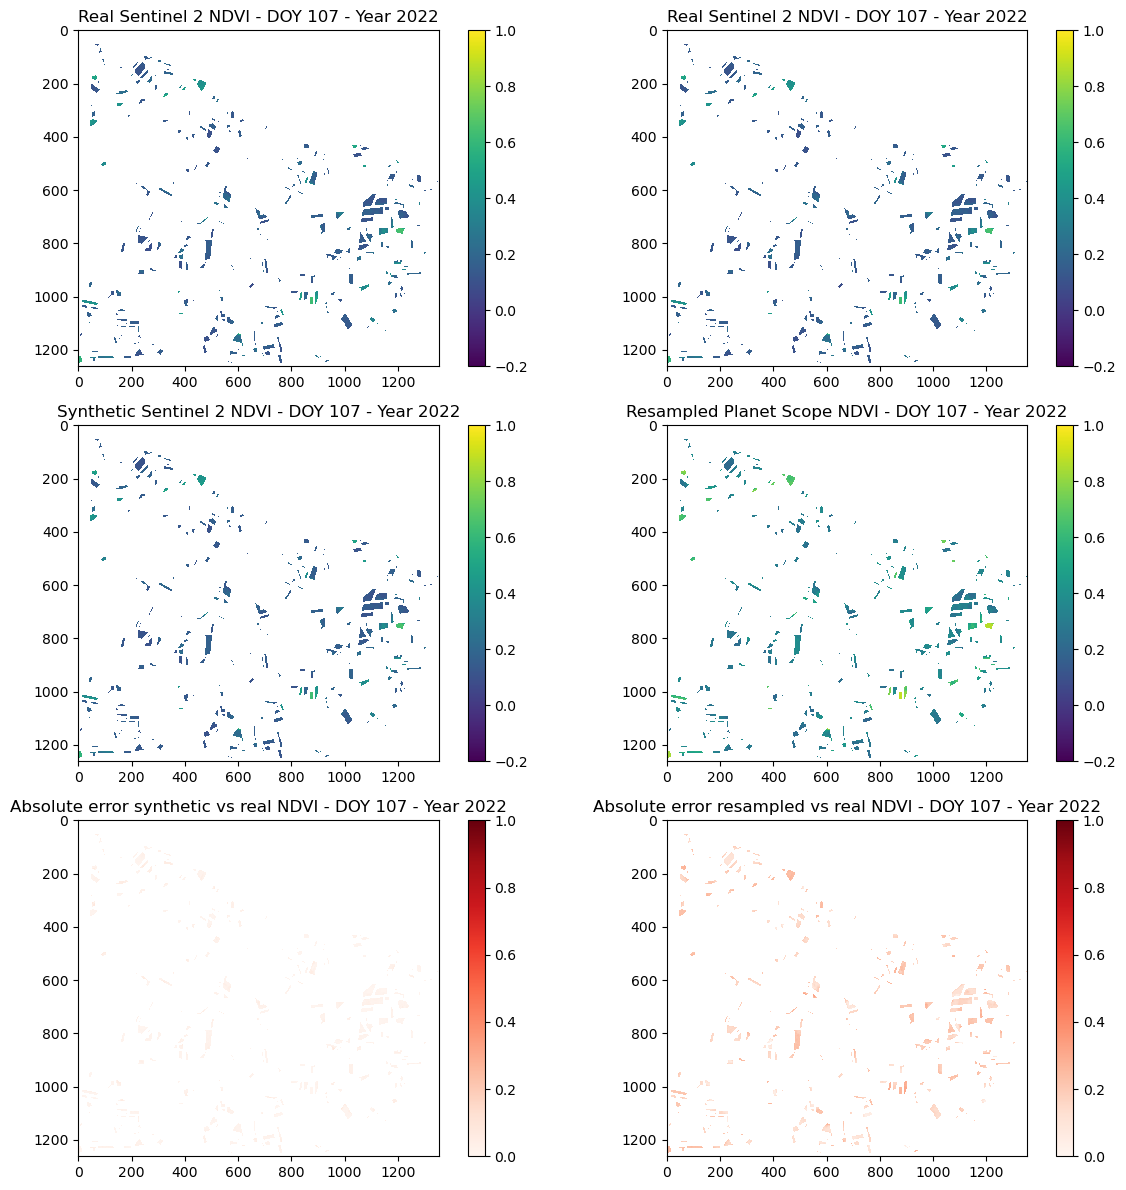

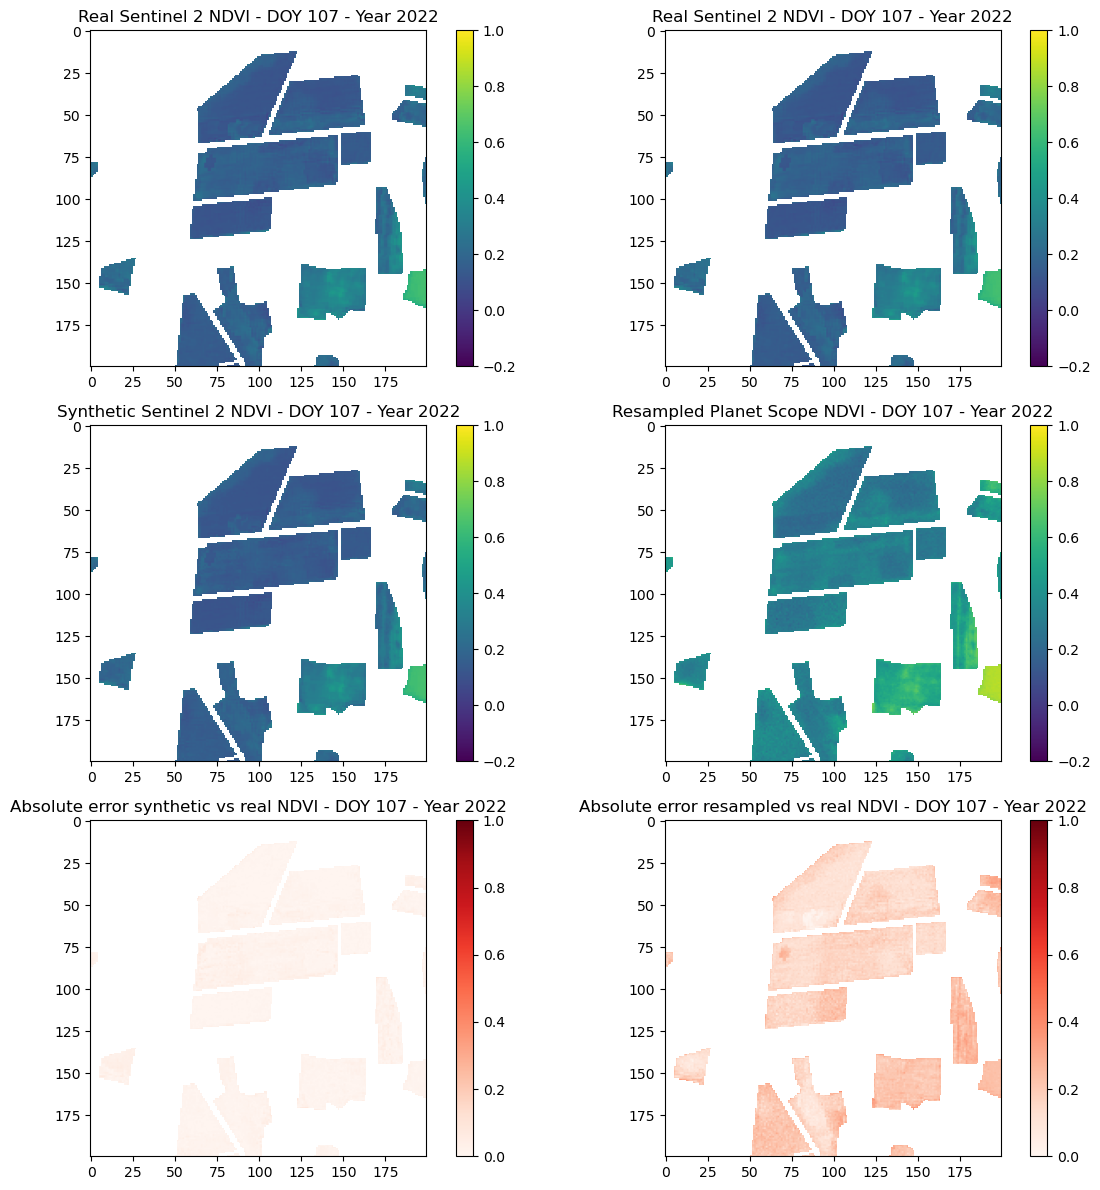

Mean Squared Error for Synthetic Planetscope DOY 107: 0.0006289300836645641
Mean Squared Error for Resampled Planetscope DOY 107: 0.03717946261167526


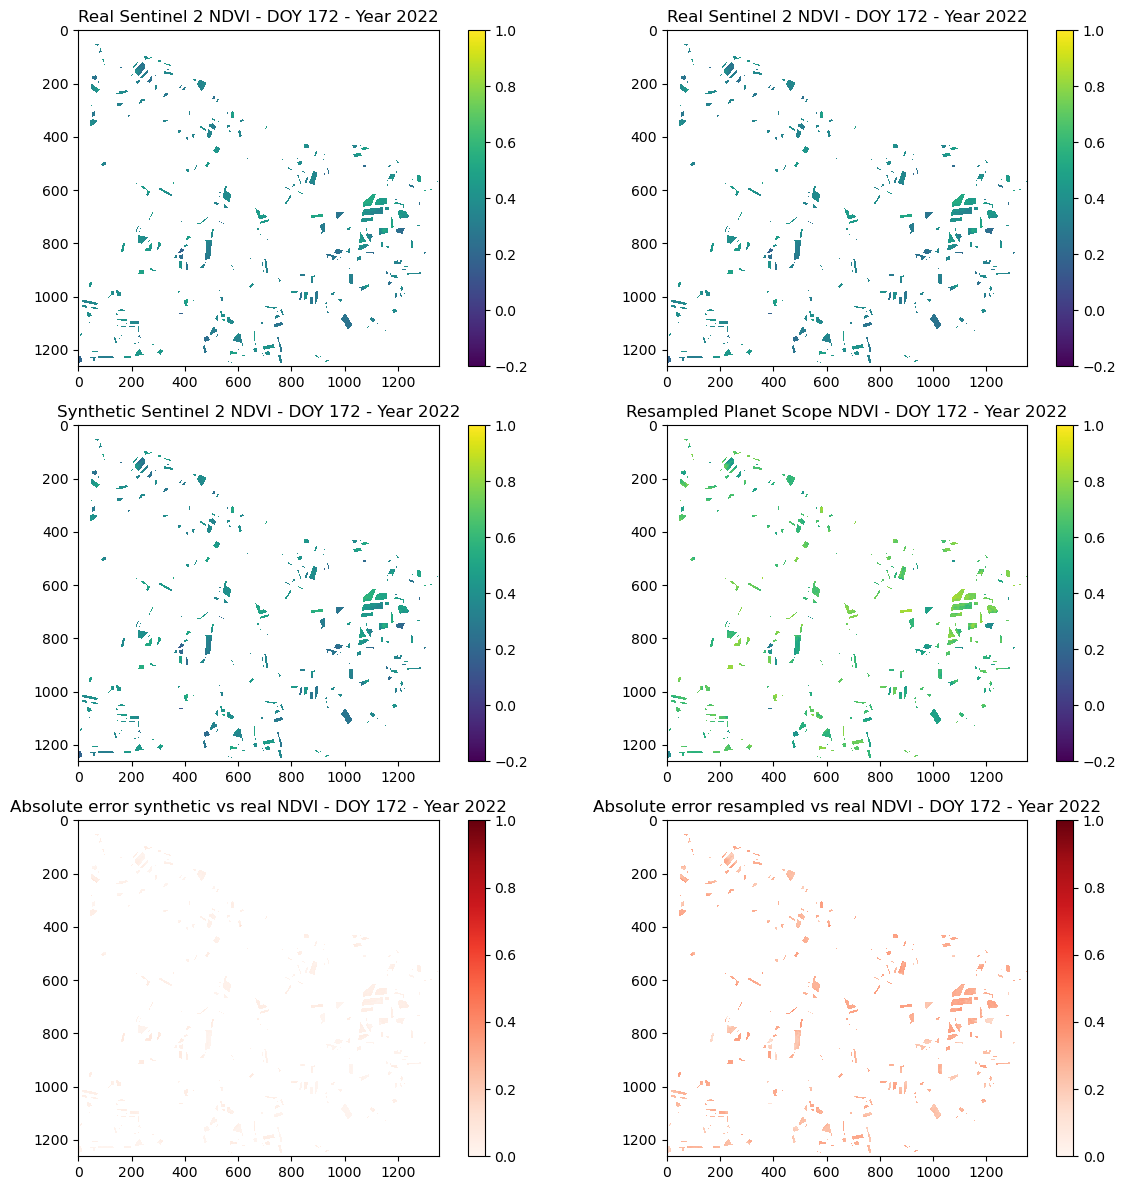

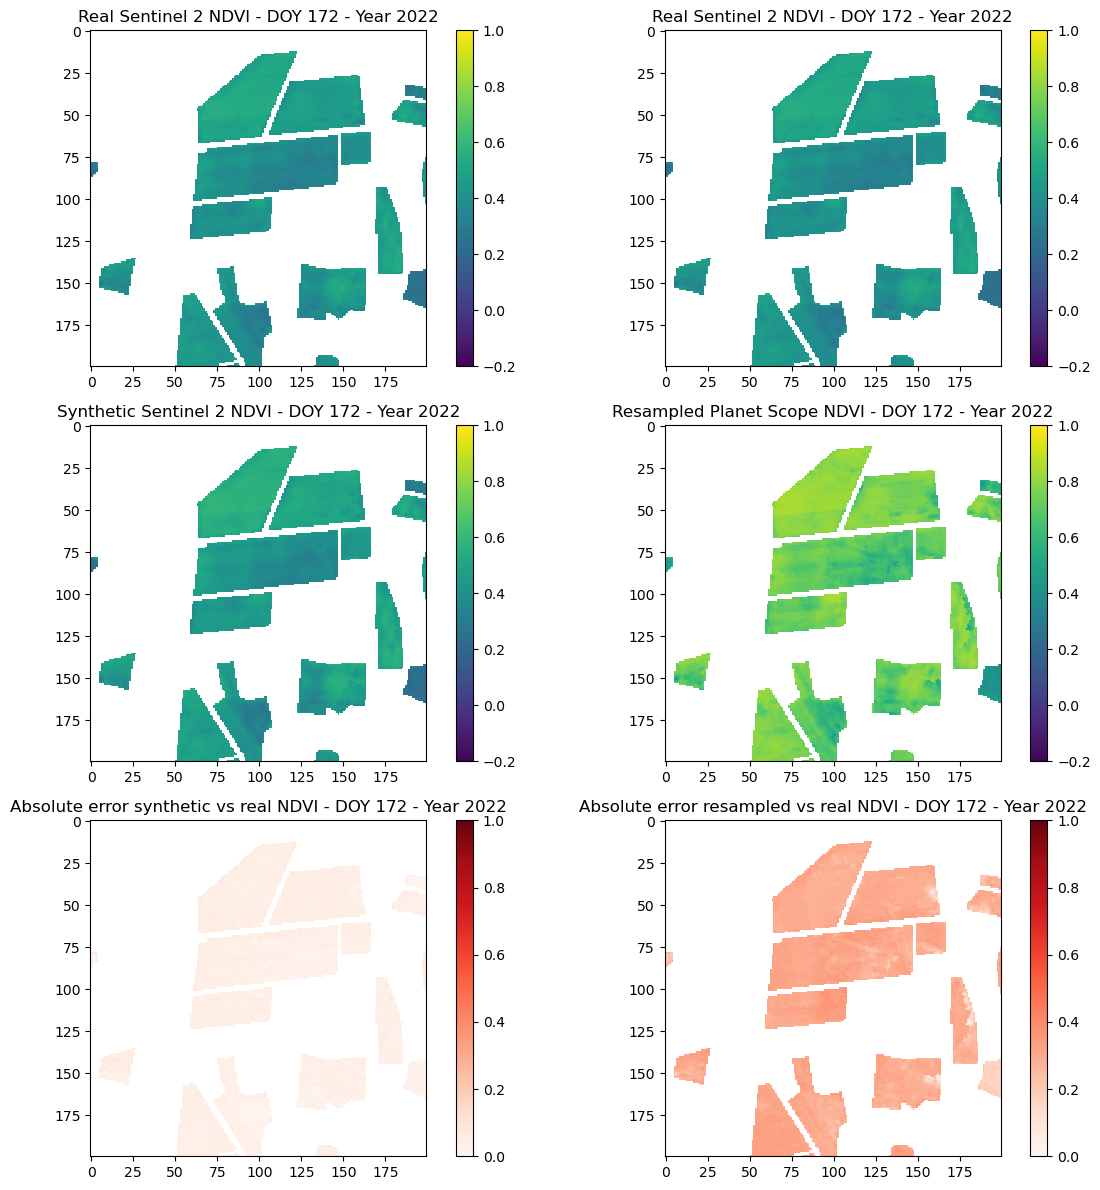

Mean Squared Error for Synthetic Planetscope DOY 172: 0.0011347061740525984
Mean Squared Error for Resampled Planetscope DOY 172: 0.07480375468730927


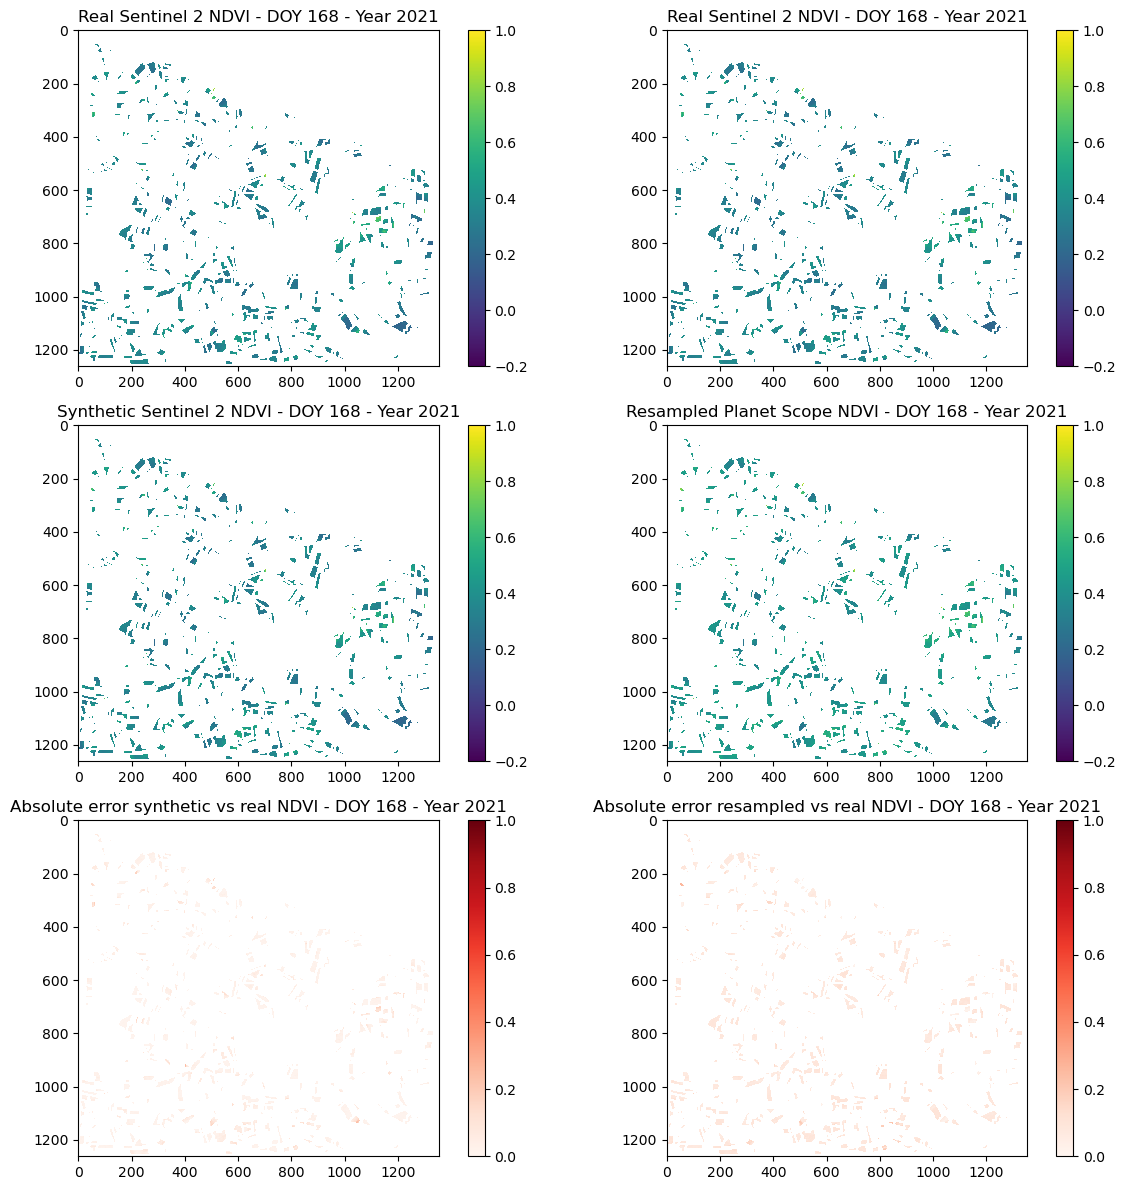

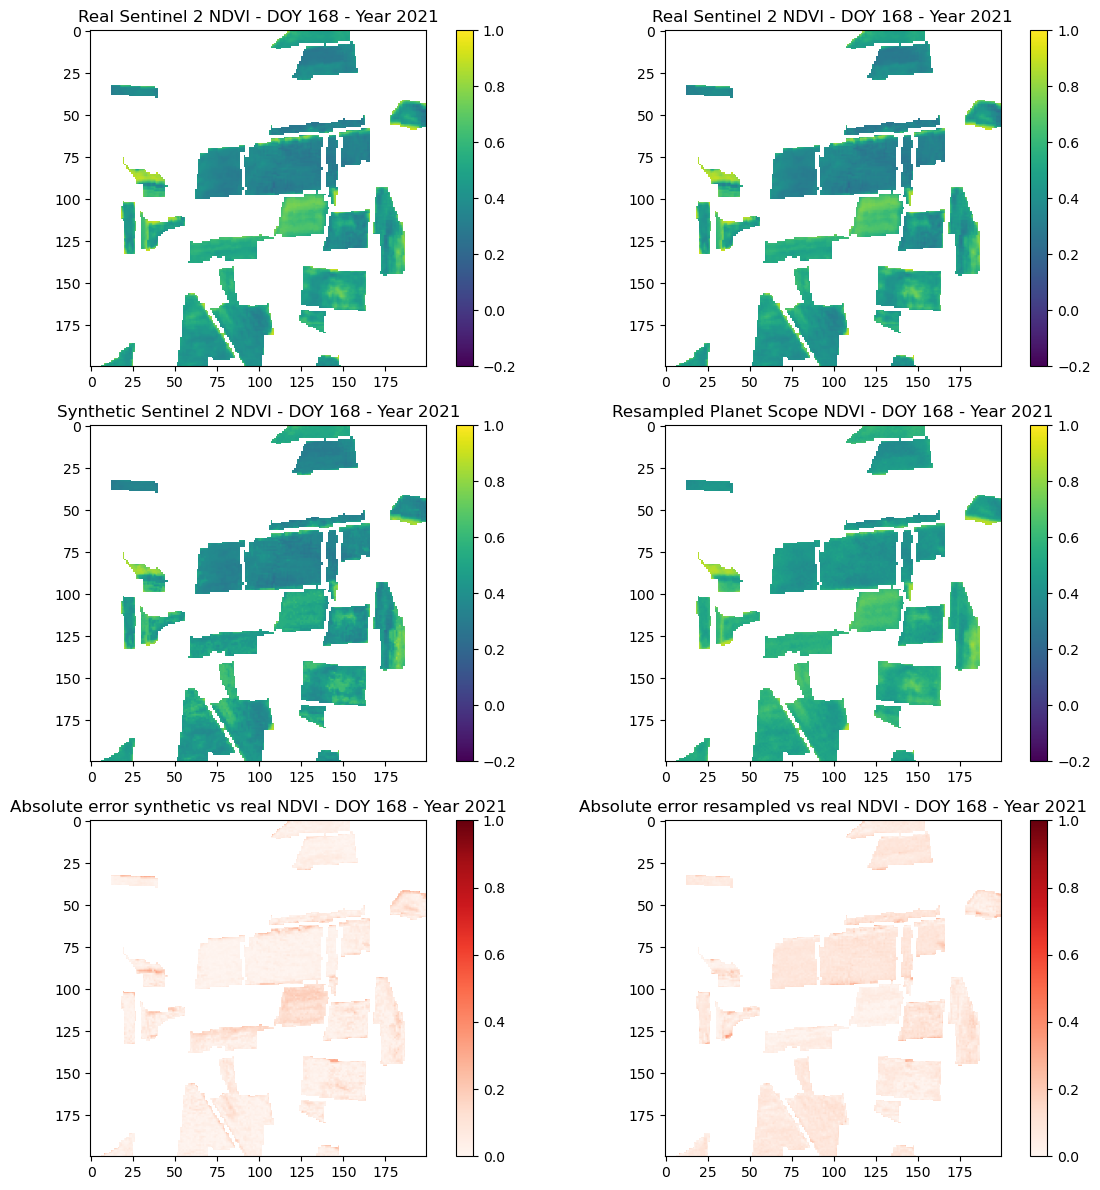

Mean Squared Error for Synthetic Planetscope DOY 168: 0.003725088854629178
Mean Squared Error for Resampled Planetscope DOY 168: 0.008268403820693493


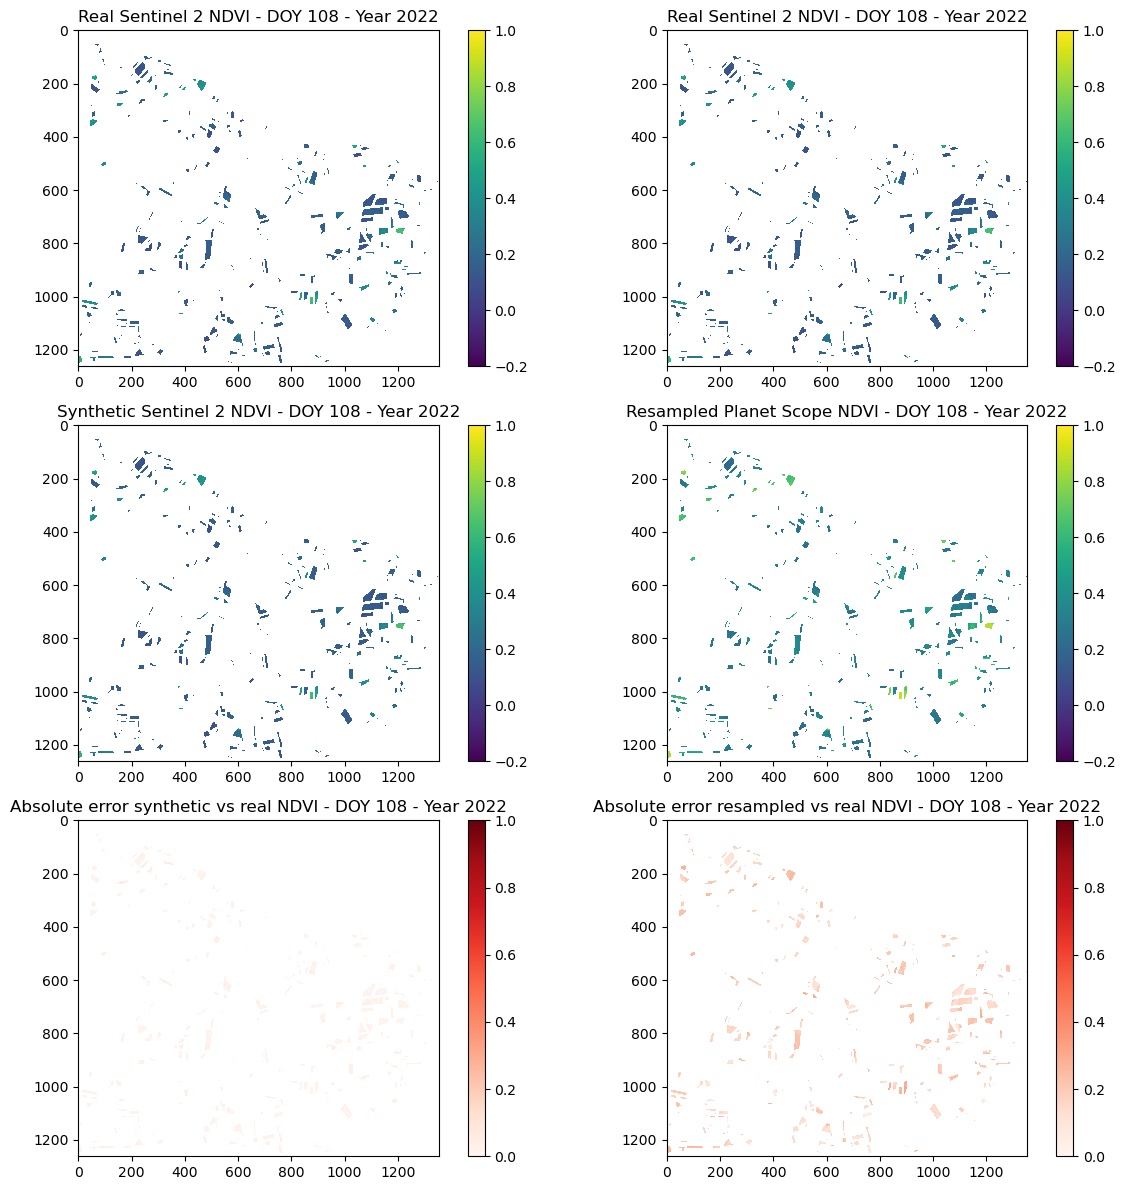

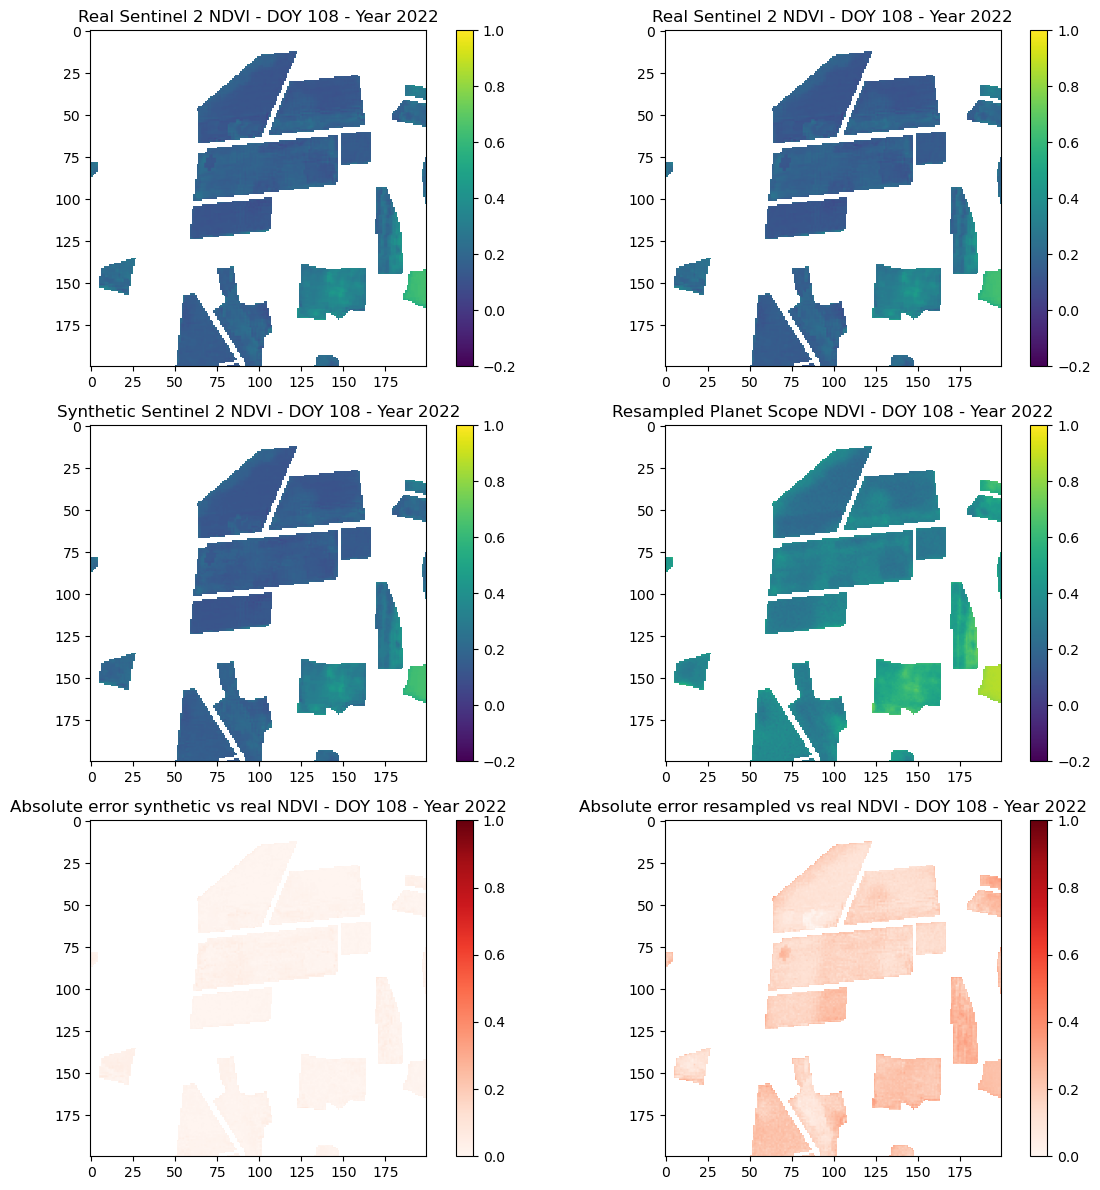

Mean Squared Error for Synthetic Planetscope DOY 108: 0.000608759265739636
Mean Squared Error for Resampled Planetscope DOY 108: 0.03833768889307976


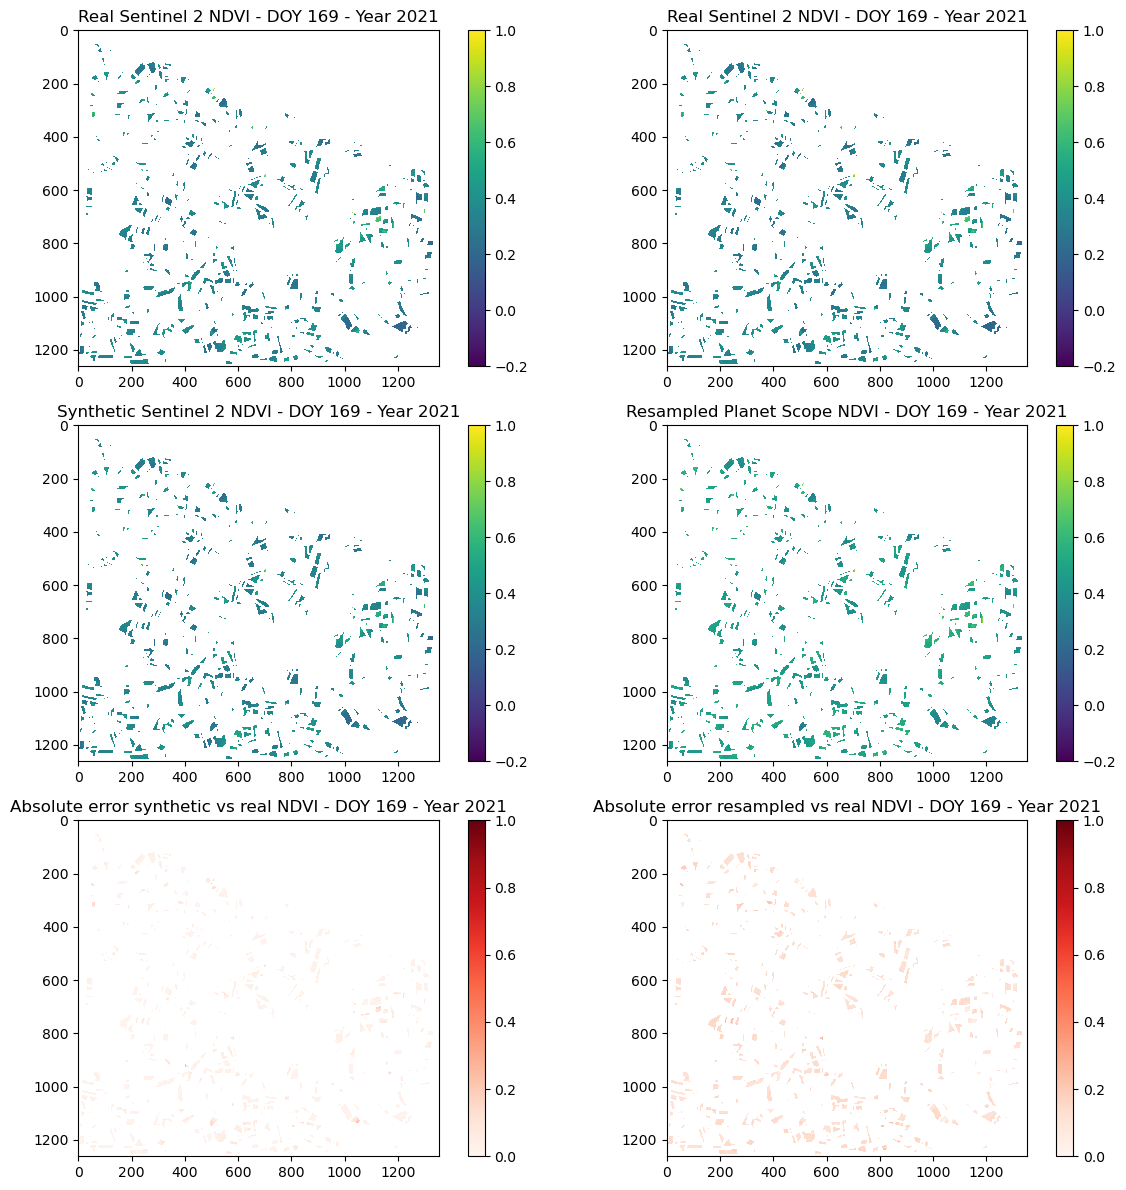

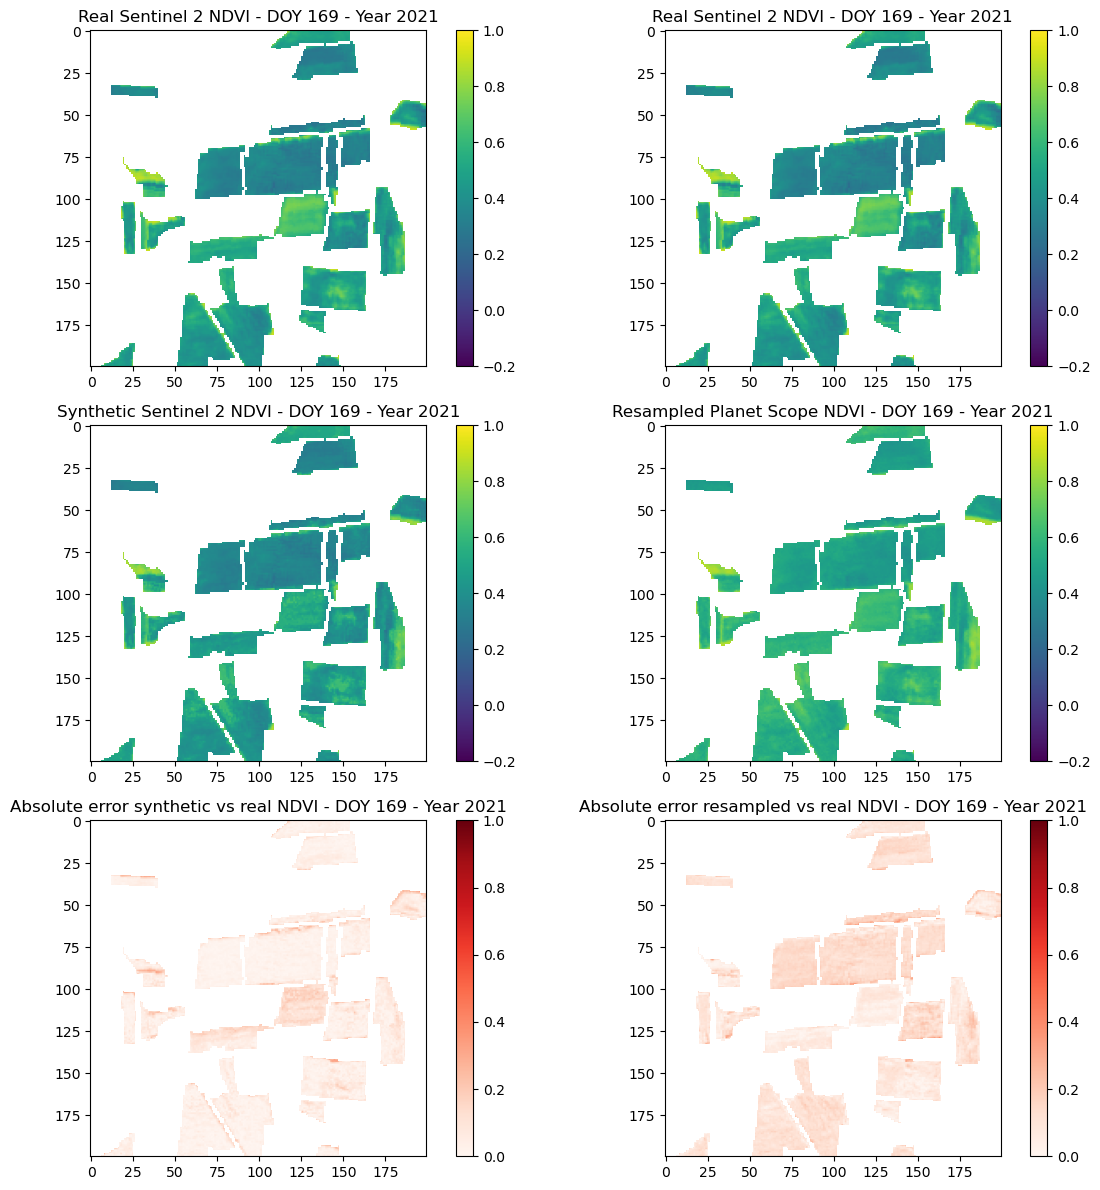

Mean Squared Error for Synthetic Planetscope DOY 169: 0.003528707600207883
Mean Squared Error for Resampled Planetscope DOY 169: 0.016183366999030113


In [13]:
import copy

all_features = []
all_targets = []
all_masks = []
for match in validation_pairs:
    if match["year"] == 2021:
        X, y, invalid_mask = create_feature_target_pair(
            match,
            sentinel_2_images_2021,
            planet_scope_images_2021,
            "maize_shp/2021_fid40_maize_utm_10mbuffer.shp",
        )
    else:
        X, y, invalid_mask = create_feature_target_pair(
            match,
            sentinel_2_images_2022,
            planet_scope_images_2022,
            "maize_shp/2022_fid40_maize_utm_10mbuffer.shp",
        )
    all_features.append(X)
    all_targets.append(y)
    all_masks.append(invalid_mask)

# Evaluate and visualize within a single loop
mse_dict_synth = {}
mse_dict_resampled = {}
mean_ndiv_dict_synth = {}
mean_ndiv_dict_resampled = {}
mean_ndiv_dict_real = {}
for i, match in enumerate(validation_pairs):
    year = match["year"]
    if year == 2022:
        sentinel_2_images = sentinel_2_images_2022
        planet_scope_images = planet_scope_images_2022
    else:
        sentinel_2_images = sentinel_2_images_2021
        planet_scope_images = planet_scope_images_2021

    planet_doy = match["planet_doy"]
    sentinel_matching_doy = match["sentinel_matching_doy"]

    # Make predictions
    predictions = rf_model.predict(all_features[i])

    # Create synthetic image
    synth_image = copy.deepcopy(sentinel_2_images[sentinel_matching_doy])
    synth_image.ndvi[~all_masks[i]] = predictions

    save_tif(synth_image.ndvi, f"output/{year}-{planet_doy}-random-forest.tif", synth_image.crs, synth_image.transform)

    # Resampled PlanetScope for comparison
    resampled_image = processor.resample_planet_to_sentinel(
        sentinel_2_images[sentinel_matching_doy],
        planet_scope_images[planet_doy],
    )
    if year == 2022:
        resampled_image.ndvi = processor.mask_array_with_shapefile(
            resampled_image.ndvi,
            resampled_image.transform,
            "maize_shp/2022_fid40_maize_utm_10mbuffer.shp",
        )
    else:
        resampled_image.ndvi = processor.mask_array_with_shapefile(
            resampled_image.ndvi,
            resampled_image.transform,
            "maize_shp/2021_fid40_maize_utm_10mbuffer.shp",
        )

    # Visualize using your NDVIVisualizer
    visualizer = NDVIVisualizer()
    visualizer.visualize_ndvi_images(
        sentinel_2_images[sentinel_matching_doy].ndvi,
        synth_image.ndvi,
        resampled_image.ndvi,
        planet_doy,
        year
    )

    cropout_sentinel_2_ndvi = sentinel_2_images[sentinel_matching_doy].ndvi[
        600:800, 1000:1200
    ]
    cropout_synth_ndvi = synth_image.ndvi[600:800, 1000:1200]
    cropout_resampled_ndvi = resampled_image.ndvi[600:800, 1000:1200]

    visualizer.visualize_ndvi_images(
        cropout_sentinel_2_ndvi,
        cropout_synth_ndvi,
        cropout_resampled_ndvi,
        planet_doy,
        year
    )

    # Calculate MSE
    mse_synth = mean_squared_error(all_targets[i], predictions)

    print(f"Mean Squared Error for Synthetic Planetscope DOY {planet_doy}: {mse_synth}")

    mse_resampled = mean_squared_error(
        all_targets[i],
        processor.get_preprocessed_ndiv_data(resampled_image, all_masks[i]),
    )

    print(
        f"Mean Squared Error for Resampled Planetscope DOY {planet_doy}: {mse_resampled}"
    )

    mse_dict_synth[planet_doy] = mse_synth
    mse_dict_resampled[planet_doy] = mse_resampled
    mean_ndiv_dict_synth[planet_doy] = np.mean(predictions)
    mean_ndiv_dict_resampled[planet_doy] = np.nanmean(resampled_image.ndvi)
    mean_ndiv_dict_real[planet_doy] = np.nanmean(
        sentinel_2_images[sentinel_matching_doy].ndvi
    )


visualizer.plot_time_series(mse_dict_synth, mse_dict_resampled, mean_ndiv_dict_synth, mean_ndiv_dict_resampled, mean_ndiv_dict_real)

In [14]:
print(f"Total Error Resampled: {sum(mse_dict_resampled.values())}")
print(f"Total Error Synthetic: {sum(mse_dict_synth.values())}")

Total Error Resampled: 0.1747726770117879
Total Error Synthetic: 0.009626191978293858
